<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visual-processing-as-a-cascade-of-filtering-operations" data-toc-modified-id="Visual-processing-as-a-cascade-of-filtering-operations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visual processing as a cascade of filtering operations</a></span><ul class="toc-item"><li><span><a href="#The-receptive-field-of-a-visual-neuron-as-a-filter" data-toc-modified-id="The-receptive-field-of-a-visual-neuron-as-a-filter-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>The receptive field of a visual neuron as a filter</a></span></li><li><span><a href="#Receptive-fields-of-retinal-ganglion-cells-and-cells-in-LGN" data-toc-modified-id="Receptive-fields-of-retinal-ganglion-cells-and-cells-in-LGN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Receptive fields of retinal ganglion cells and cells in LGN</a></span><ul class="toc-item"><li><span><a href="#Option-1:-go-with-generic-DOG" data-toc-modified-id="Option-1:-go-with-generic-DOG-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Option 1: go with generic DOG</a></span></li><li><span><a href="#Option-2:-go-with-actual-RFs" data-toc-modified-id="Option-2:-go-with-actual-RFs-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Option 2: go with actual RFs</a></span></li></ul></li><li><span><a href="#Receptive-fields-of-cells-in-V1" data-toc-modified-id="Receptive-fields-of-cells-in-V1-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Receptive fields of cells in V1</a></span></li></ul></li><li><span><a href="#Spatiotemporal-properties-of-the-visual-system" data-toc-modified-id="Spatiotemporal-properties-of-the-visual-system-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Spatiotemporal properties of the visual system</a></span><ul class="toc-item"><li><span><a href="#The-contrast-sensitivity-function" data-toc-modified-id="The-contrast-sensitivity-function-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The contrast sensitivity function</a></span></li><li><span><a href="#The-CSF-and-multi-scale-spatial-filtering" data-toc-modified-id="The-CSF-and-multi-scale-spatial-filtering-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>The CSF and multi-scale spatial filtering</a></span></li></ul></li><li><span><a href="#Other-applications" data-toc-modified-id="Other-applications-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other applications</a></span><ul class="toc-item"><li><span><a href="#Multi-scale-spatial-filtering-and-brightness-perception" data-toc-modified-id="Multi-scale-spatial-filtering-and-brightness-perception-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Multi-scale spatial filtering and brightness perception</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import scipy.fft
import scipy.signal
import matplotlib.pyplot as plt
from ipywidgets import interactive as interactive
from ipywidgets import FloatSlider
import cv2

%matplotlib inline

In [2]:
# Parameters and read-in image
ppd = 128.             # Spatial resolution, pixels per degree
extent = (-5, 5,)  # Visual extent in deg

nX = int(extent[1]*ppd - extent[0]*ppd)
x = np.linspace(extent[0], extent[1], nX, endpoint=False)
yy, xx = np.meshgrid(x, x)

f = scipy.fft.fftshift(scipy.fft.fftfreq(nX, d=(1/ppd)))
fy, fx = np.meshgrid(f, f)
fextent = (f.min(), f.max(),)

# Read-in an image
img = cv2.cvtColor(cv2.imread('monroe.png'), cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, [nX, nX]) / 255

## Visual processing as a cascade of filtering operations

### The receptive field of a visual neuron as a filter

In the first layers of visual processing (retina, LGN, V1, ...), cells are spatially arranged
in a way that adjacent cells respond to partially overlapping portions of the visual field.

We tend to characterize these cells based on their so-called receptive field properties.
The receptive field of a cell is the region of the visual field that makes a cell change its
firing in the presence of a certain visual stimulation.
The type of visual stimulation that a cell preferrably responds to can differ both in their
spatial as well as temporal properties.
Analogously, we can model the behavior of visual cells using spatial and temporal filters.

<img src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif" width="500"/>
<center>  Animation of a convolution. <a href="https://en.wikipedia.org/wiki/Convolution">wikipedia</a></center>  

<img src="https://miro.medium.com/max/1400/1*bv7EBb98fNmocOkESULgRQ.png" width="800"/>
<center>  Vision as a cascade of filtering operations. <a href="https://lamiae-hana.medium.com/an-intro-to-convolutional-neural-networks-cnn-9f1c2d888fa1">ref</a></center>  

But what are the features that the early visual system is most sensitive to?
The receptive field properties that are most studied and can be best described, are the
receptive fields of retinal ganglion cells, cells in LGN and simple and complex cells in V1.

Let's have a look into some characteristics of cells along the first layers of visual processing.

### Receptive fields of retinal ganglion cells and cells in LGN

The repective fields of retinal ganglion cells and LGN cells are often described as
concentric (ie circular) center-surround receptive fields that either respond to
light increments in the center and decrements in the surround (ON-center-OFF-surround)
or they respond to light decrements in the center and light increments in the surround
(OFF-center-ON-surround).

We can model their behavior using DOG-filters [(Rodieck, 1965)](https://doi.org/10.1016/0042-6989(65)90033-7)

#### Option 1: go with generic DOG

In [15]:
def gaussian2d(x, y, sigma, orientation=0):
    # determine a, b, c coefficients
    a = (np.cos(orientation)**2 / (2*sigma[0]**2)) + (np.sin(orientation)**2 / (2*sigma[1]**2))
    b = -(np.sin(2*orientation) / (4*sigma[0]**2)) + (np.sin(2*orientation) / (4*sigma[1]**2))
    c = (np.sin(orientation)**2 / (2*sigma[0]**2)) + (np.cos(orientation)**2 / (2*sigma[1]**2))

    # create Gaussian
    gaussian = np.exp(-(a*x**2 + 2*b*x*y + c*y**2))
    return gaussian


def create_odog(xx, yy, sigma_c, sigma_s, orientation):
    # Create center and surround anisotropic Gaussian filters
    center = gaussian2d(xx, yy, sigma=sigma_c, orientation=orientation)
    surround = gaussian2d(xx, yy, sigma=sigma_s, orientation=orientation)

    # Normalize each filter by its total sum
    center = center / center.sum()
    surround = surround / surround.sum()
    return center - surround

In [16]:
def plot_dog(sigma_c, sigma_s):
    dog = create_odog(xx, yy, (sigma_c, sigma_c), (sigma_s, sigma_s), 0)
    plt.imshow(dog, extent=extent*2, cmap='coolwarm')

interactive(plot_dog, sigma_c=(0.01, 0.1, 0.01), sigma_s=(0.02, 0.2, 0.01))

interactive(children=(FloatSlider(value=0.05, description='sigma_c', max=0.1, min=0.01, step=0.01), FloatSlide…

In [24]:
def dog_filtering(sigma_c, sigma_s):
    dog = create_odog(xx, yy, (sigma_c, sigma_c), (sigma_s, sigma_s), 0)
    imfilt_ON = scipy.signal.fftconvolve(img, dog, "same")
    imfilt_OFF = scipy.signal.fftconvolve(img, -dog, "same")
    
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.imshow(img, cmap='gray', extent=extent*2)
    plt.subplot(142)
    plt.imshow(dog, extent=extent*2)
    plt.subplot(143)
    plt.imshow(imfilt_ON, cmap='coolwarm', extent=extent*2), plt.title('ON-center')
    plt.subplot(144)
    plt.imshow(imfilt_OFF, cmap='coolwarm', extent=extent*2), plt.title('OFF-center')

interactive(dog_filtering, sigma_c=(0.02, 0.2, 0.01), sigma_s=(0.04, 0.4, 0.01))

interactive(children=(FloatSlider(value=0.11, description='sigma_c', max=0.2, min=0.02, step=0.01), FloatSlide…

#### Option 2: go with actual RFs

In [9]:
# Create spatial RF of retinal ganglion cells
def spatialRF_retina(fx, fy, rc, Kc, rs, Ks):
    # Spatial response profile in frequency domain
    center = Kc * np.pi * rc**2. * np.exp(-(np.pi*rc*np.sqrt(fx**2.+fy**2.))**2.)
    surround = Ks * np.pi * rs**2. * np.exp(-(np.pi*rs*np.sqrt(fx**2.+fy**2.))**2.)
    rf = center - surround
    
    # Originally, they are not balanced
    rf[int(nX/2), int(nX/2)] = 0
    return rf

In [10]:
# Values taken from Croner & Kaplan (1995)
spatial_Mcell = spatialRF_retina(fx, fy, rc=0.1, Kc=148., rs=0.72, Ks=1.1)
spatial_Pcell = spatialRF_retina(fx, fy, rc=0.03, Kc=325.2, rs=0.18, Ks=4.4)

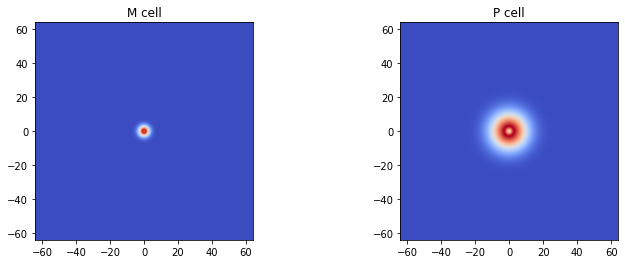

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(spatial_Mcell, extent=fextent*2, cmap='coolwarm'), plt.title('M cell')

plt.subplot(122)
plt.imshow(spatial_Pcell, extent=fextent*2, cmap='coolwarm'), plt.title('P cell')
plt.show()

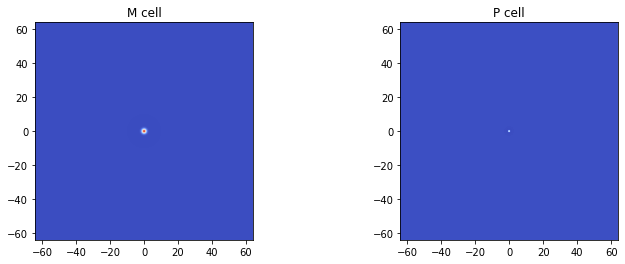

2.3071822230491534e-16
-1.6393136847980827e-16


In [30]:
# These are not balanced
blub = np.real(scipy.fft.ifftshift(scipy.fft.ifft2(scipy.fft.ifftshift(spatial_Mcell))))
blab = np.real(scipy.fft.ifftshift(scipy.fft.ifft2(scipy.fft.ifftshift(spatial_Pcell))))

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(blub, extent=fextent*2, cmap='coolwarm'), plt.title('M cell')

plt.subplot(122)
plt.imshow(blab, extent=fextent*2, cmap='coolwarm'), plt.title('P cell')
plt.show()

print(blub.sum())
print(blab.sum())

In [31]:
# Apply to an image
im_Mcell = scipy.signal.fftconvolve(img, blub, "same")
im_Pcell = scipy.signal.fftconvolve(img, blab, "same")

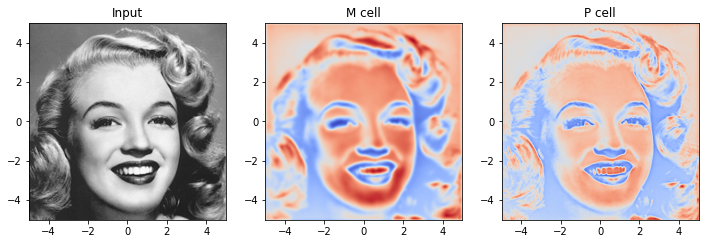

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(img, cmap='gray', extent=extent*2), plt.title('Input')

plt.subplot(132)
plt.imshow(im_Mcell, cmap='coolwarm', extent=extent*2), plt.title('M cell')

plt.subplot(133)
plt.imshow(im_Pcell, cmap='coolwarm', extent=extent*2), plt.title('P cell')
plt.show()

### Receptive fields of cells in V1
Compared to retinal ganglion cells and LGN cells, cells in V1 have two relevant properties:
1. Spatial-frequency-tuning
2. Orientation tuning

Thus, cell in V1 are often described as a multitude of filters that respond best to
a variety of different spatial frequencies and orientations.

One way to model the behavior of simple cells is by using ODOG-filters.

In [28]:
def plot_odog(sigma_c, orientation):
    odog = create_odog(xx, yy, (sigma_c, sigma_c), (sigma_c, sigma_c*2), orientation*np.pi/180.)
    plt.imshow(odog, extent=extent*2, cmap='coolwarm')

interactive(plot_odog, sigma_c=(0.02, 0.2, 0.01), orientation=(0, 90))

interactive(children=(FloatSlider(value=0.11, description='sigma_c', max=0.2, min=0.02, step=0.01), IntSlider(…

In [36]:
def odog_filtering(sigma_c, orientation):
    odog = create_odog(xx, yy, (sigma_c, sigma_c), (sigma_c, sigma_c*2), orientation*np.pi/180.)
    imfilt = scipy.signal.fftconvolve(img, odog, "same")
    
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.imshow(img, cmap='gray', extent=extent*2)
    plt.subplot(142)
    plt.imshow(odog, extent=extent*2)
    plt.subplot(143)
    plt.imshow(imfilt, cmap='coolwarm', extent=extent*2)

interactive(odog_filtering, sigma_c=(0.02, 0.2, 0.01), orientation=(0, 90))

interactive(children=(FloatSlider(value=0.11, description='sigma_c', max=0.2, min=0.02, step=0.01), IntSlider(…

## Spatiotemporal properties of the visual system

### The contrast sensitivity function

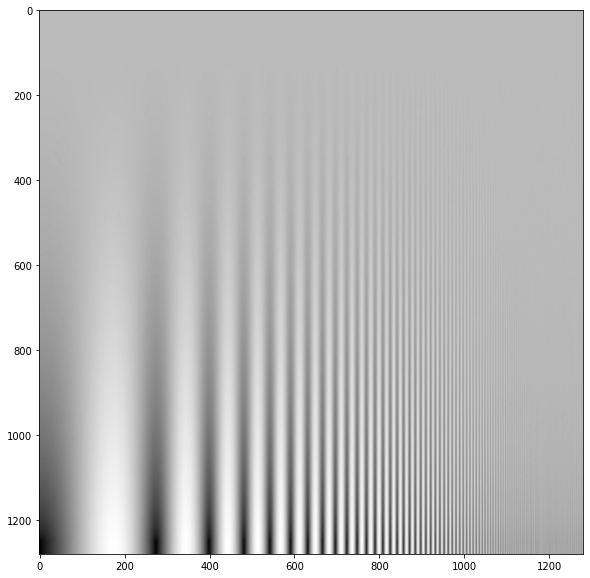

In [45]:
# Read-in CSF image
img_csf = cv2.cvtColor(cv2.imread('CSF.jpg'), cv2.COLOR_BGR2GRAY)
img_csf = cv2.resize(img, [nX, nX]) / 255

plt.figure(figsize=(10,10))
plt.imshow(img_csf, cmap='gray')
plt.show()

### The CSF and multi-scale spatial filtering

In [53]:
# Spatiotemporal csf functions taken from Kelly1979:
def human_csf(sfs, tf):
    # The equation does not allow sf=0, so we implement a small workaround
    sfs2 = np.copy(sfs)
    idx = np.where(sfs2 == 0.)
    sfs2[sfs == 0.] = 1.
    
    # Calculate "velocity" needed for formula
    v = tf / sfs2
    
    # Calculate contrast sensitivity function:
    k = 6.1 + 7.3 * np.abs(np.log10(v/3.))**3.
    amax = 45.9 / (v + 2.)
    csf = k * v * (2.*np.pi*sfs2)**2. * np.exp((-4.*np.pi*sfs2) / amax)
    csfplt = 1. / csf
    
    if len(idx):
        csf[idx] = 0.
        csfplt[idx] = 0.
    return csf, csfplt

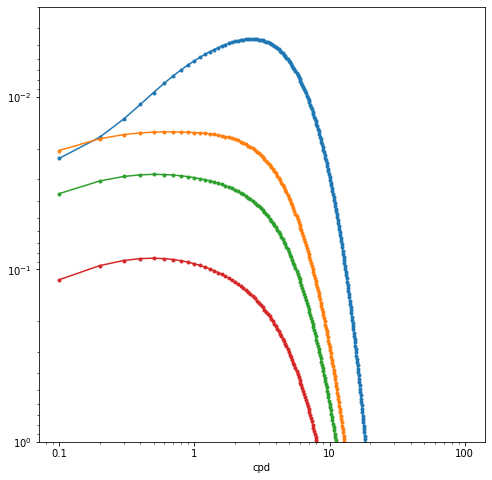

In [64]:
# Plotting
a = np.linspace(0.1, 100, 1000)
w_all = np.array([2., 13.5, 17., 23.])

plt.figure(figsize=(8, 8))
for i in range(len(w_all)):
    csf, csfplt = human_csf(a, w_all[i])
    plt.plot(a, csfplt, '.-', label=str(w_all[i]) + ' Hz')
plt.xlabel('cpd'), plt.xscale('log'), plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.yscale('log'), plt.ylim(1, 0.003)
plt.show()

## Other applications

### Multi-scale spatial filtering and brightness perception